**Brian Blaylock**  
*December 20, 2018*
 
# Find Nearest Latitude/Longitude Grid Box 
This is a nearest-neighbor approach to finding the nearest grid box to any latitude and longitude. 
 
I deal a lot with weather model output (specifically HRRR model data) and need to verify a point in the gridded data with observational data at a point. The difficulty is that weather stations I get observation data are not located at thexact grid points as the model output. The hard part to make a comparison is finding the index value of a latitude and longitude grid point nearest to the observation location. Finding the nearest model grid point, however, is easy to do with numpy's `maximum` function (not max).

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

First, you need to have three arrays of gridded model data: 
- 2D array of grid latitude 
- 2D array of grid longitude 
- 2D array of grid data, such as temperature. 
 
In this example, I create some data, but I usually load the data form grib2, netcdf, or hdf5 files.

In [2]:
# Latitudes ",
longitude = np.arange(-120, -100, .5)

# Longitudes
latitude = np.arange(30, 45, .5)

# Use meshgrid to make 2D arrays of the lat/lon data
lats, lons = np.meshgrid(latitude, longitude)

# A 2D numpy array of your temperatures, or some other variable, that matches the lat/lon grid 
# Generate randomized test data for now
data = np.random.randint(50, size=np.shape(lats))

Next, you need to know the latitude and longitude for the observation point. We are looking for the nearest grid point in the lat and lon arrays for that grid point.

In [3]:
stn_lat = 40.32
stn_lon = -110.29

### Plot the simulated gridded model data and the point of interest
Generate a plot of the data. We want to find the value of the grid box nearest to `40.32, -110.29`.

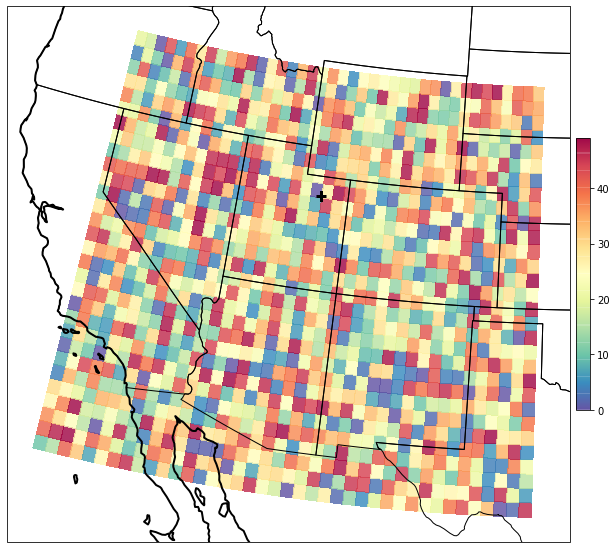

In [16]:
projection = ccrs.LambertConformal(
    central_longitude = -97.5,
    central_latitude = 38.5,
    standard_parallels = (38.5,38.5),
    cutoff = 0)

fig = plt.figure(figsize=[12, 10])
ax = plt.axes(projection=projection)
D = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap='Spectral_r', alpha=.8)
fig.colorbar(D, ax=ax, shrink=.5, pad=.01)
ax.scatter(stn_lon, stn_lat, transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'))

Now find the absolute value of the difference between the station's lat/lon with every point in the grid. This tells us how close a point is to the particular latitude and longitude.

In [5]:
abslat = np.abs(lats-stn_lat)
abslon= np.abs(lons-stn_lon)

If you plot abslat and abslon, you'll see what we have done...we have created two new arrays with that tell us how close each latitude and longitude is to the grid point we are interested in.

Text(0.5, 1.0, 'Longitude Absolute Difference')

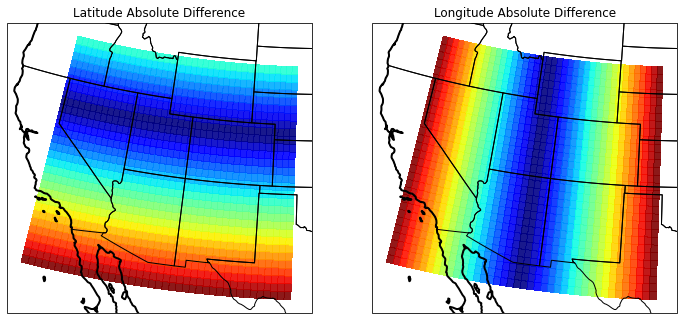

In [6]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(1,2,1, projection=projection)
ax2 = fig.add_subplot(1,2,2, projection=projection)

ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax1.add_feature(cfeature.STATES.with_scale('50m'))
ax1.pcolormesh(lons, lats, abslat, transform=ccrs.PlateCarree(), cmap='jet', alpha=.9)
ax1.set_title("Latitude Absolute Difference")

ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax2.add_feature(cfeature.STATES.with_scale('50m'))
ax2.pcolormesh(lons, lats, abslon, transform=ccrs.PlateCarree(), cmap='jet', alpha=.9)
ax2.set_title("Longitude Absolute Difference")

Now we need to combine these two results. We will use numpy.maximum, which takes two arrays and finds the local maximum.


In [7]:
c = np.maximum(abslon, abslat)

Text(1.0, 1.0, 'Minimum Grid Cell Location: [[19 21]]')

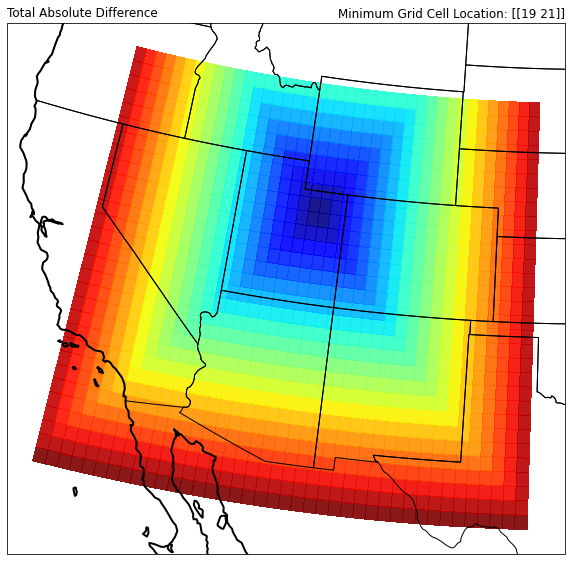

In [8]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=projection)

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.pcolormesh(lons, lats, c, transform=ccrs.PlateCarree(), cmap='jet', alpha=.9)

ax.set_title("Total Absolute Difference", loc='left')
ax.set_title('Minimum Grid Cell Location: %s' % np.argwhere(c==c.min()), loc='right')

Now, this latitude/longitude index value is the index for a flattened array, so when you look for that same index value in, say, your temperature array, you should flatten the array to pluck out the value at that point.

In [9]:
x, y = np.where(c == np.min(c)) 
grid_data = data[x[0], y[0]] 
grid_lat = lats[x[0], y[0]] 
grid_lon = lons[x[0], y[0]] 
 
print("Value of %s at %s %s" % (grid_data, grid_lat, grid_lon)) 
print("%s %s is the nearest grid to %s %s" % (grid_lat, grid_lon, stn_lat, stn_lon))

Value of 0 at 40.5 -110.5
40.5 -110.5 is the nearest grid to 40.32 -110.29


Text(1.0, 1.0, 'Minimum Difference Grid Cell Location: [[19 21]]')

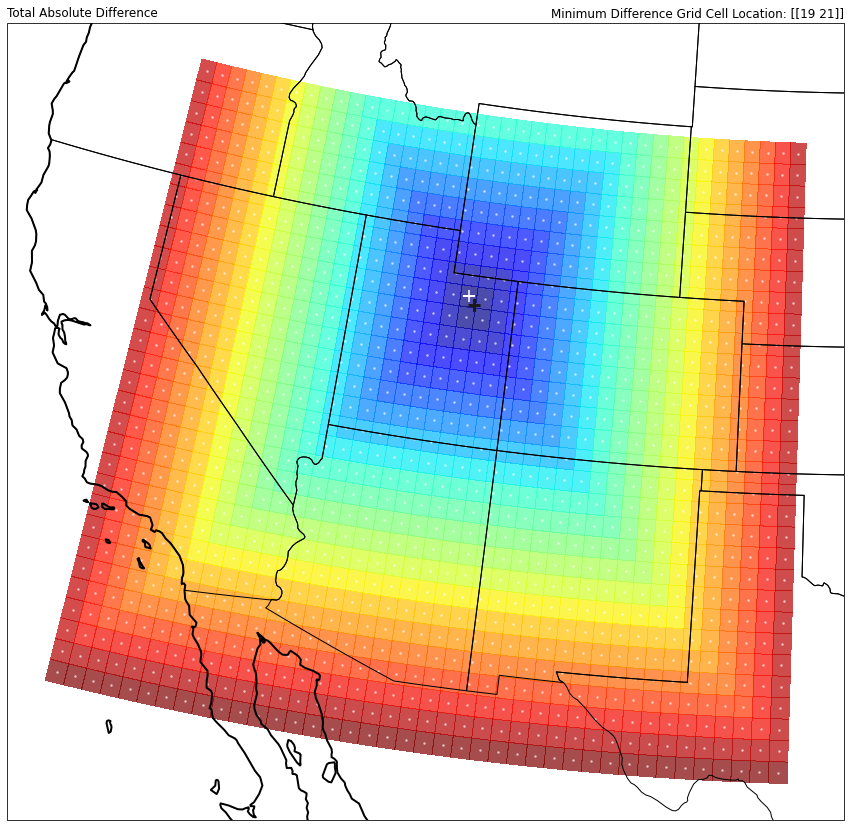

In [41]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection=projection)

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.pcolormesh(lons, lats, c, transform=ccrs.PlateCarree(), cmap='jet', alpha=.7)
ax.scatter(lons, lats, marker='.', color='w', transform=ccrs.PlateCarree(), s=10, alpha=.5)
ax.scatter(grid_lon, grid_lat, transform=ccrs.PlateCarree(), s=150, c='w', marker='+')
ax.scatter(stn_lon, stn_lat, transform=ccrs.PlateCarree(), s=150, c='.1', marker='+', lw=3)

ax.set_title("Total Absolute Difference", loc='left')
ax.set_title('Minimum Difference Grid Cell Location: %s' % np.argwhere(c==c.min()), loc='right')

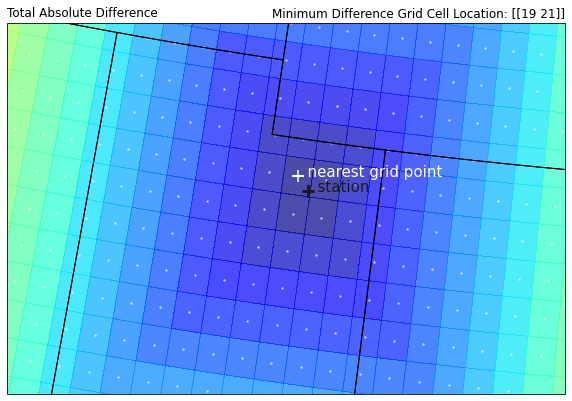

In [58]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=projection)

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.pcolormesh(lons, lats, c, transform=ccrs.PlateCarree(), cmap='jet', alpha=.7)
ax.scatter(lons, lats, marker='.', color='w', transform=ccrs.PlateCarree(), s=10, alpha=.5)

ax.scatter(grid_lon, grid_lat, transform=ccrs.PlateCarree(), s=150, c='w', marker='+')
ax.text(grid_lon, grid_lat, "  nearest grid point", transform=ccrs.PlateCarree(), c='w', fontsize=15)

ax.scatter(stn_lon, stn_lat, transform=ccrs.PlateCarree(), s=150, c='.1', marker='+', lw=3)
ax.text(stn_lon, stn_lat, "  station", transform=ccrs.PlateCarree(), c='.1', fontsize=15)

ax.set_title("Total Absolute Difference", loc='left')
ax.set_title('Minimum Difference Grid Cell Location: %s' % np.argwhere(c==c.min()), loc='right')

ax.set_extent([-115, -106, 38, 42], crs=ccrs.PlateCarree())

And there you have it! The nearest HRRR grid point to a specific location.

The above method is simple and quick if you just need the nearest neighbor for a single location. But what if you need to find the nearest neighbor for _many_ stations (like the 5,000+ NWS and RAWS stations). The best method to use in that case is a KDTreeavailable via [scipy.spatial.KDTree.query](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html#scipy.spatial.KDTree.query).

### [Demonstration of KDTree with the HRRR grid](https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/KDTree_nearest_neighbor.ipynb)